In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import h5py
import sys
from pathlib import Path

# Add the emulator code to path
sys.path.insert(0, './projects/lsst_y1/')
from emulator import ResMLP, ResTRF

In [2]:
# Check what's in the emulators folder
import os

emulator_dir = './projects/lsst_y1/emulators/'
print("Contents of emulators folder:")
for item in os.listdir(emulator_dir):
    full_path = os.path.join(emulator_dir, item)
    if os.path.isdir(full_path):
        print(f"  📁 {item}/")
    else:
        size_mb = os.path.getsize(full_path) / (1024*1024)
        print(f"  📄 {item} ({size_mb:.2f} MB)")

Contents of emulators folder:
  📄 xi_low_accuracy (2.31 MB)
  📁 lcdm_nla_halofit_ggl_trf/
  📄 xi_low_accuracy.h5 (4.66 MB)
  📄 xi_high_accuracy.h5 (4.66 MB)
  📁 lcdm_nla_halofit_wtheta_trf/
  📁 lcdm_nla_halofit_cosmic_shear_trf/
  📄 xi_high_accuracy (2.31 MB)


In [3]:
data_path = './projects/lsst_y1/data/lsst_y1_train.dataset'

# Read it as a text file
with open(data_path, 'r') as f:
    content = f.read()
    print("Contents of lsst_y1_train.dataset:")
    print(content)

Contents of lsst_y1_train.dataset:
data_file = lsst_y1_theory.modelvector
cov_file = lsst_y1_cov
mask_file = ones.mask
nz_lens_file = lsst_y1_lens.nz 
nz_source_file = lsst_y1_source.nz
lensing_overlap_cut = 0.00
lens_ntomo = 5
source_ntomo = 5
n_theta = 26
theta_min_arcmin = 2.5
theta_max_arcmin = 900.
baryon_pca_file = pca.txt



In [4]:
# Parameters (From on Evan's setup):
# ['As_1e9', 'ns', 'H0', 'omegab', 'omegam', 'LSST_DZ_S1-5', 'LSST_A1_1-2']

# Parameter ranges for LSST cosmology
n_test = 100
np.random.seed(42)

# Random test parameters
X_test = np.random.uniform(low=[1.5, 0.9, 60, 0.04, 0.25, -0.1, 0.5],
                           high=[3.0, 1.1, 80, 0.06, 0.40, 0.1, 2.0],
                           size=(n_test, 7))

print(f"Generated {n_test} test parameter sets")
print(f"Parameter shape: {X_test.shape}")
print(f"\nFirst test sample:")
print(X_test[0])

Generated 100 test parameter sets
Parameter shape: (100, 7)

First test sample:
[ 2.06181018e+00  1.09014286e+00  7.46398788e+01  5.19731697e-02
  2.73402796e-01 -6.88010959e-02  5.87125418e-01]


In [5]:
# Load the training dataset
data_path = './projects/lsst_y1/data/lsst_y1_train.dataset'
print(f"Loading data from: {data_path}")

data = np.load(data_path, allow_pickle=True).item()

# Check what's in the dataset
print("\nDataset contains:")
for key in data.keys():
    print(f"  - {key}: shape {data[key].shape if hasattr(data[key], 'shape') else type(data[key])}")

# Extract the data
X = data['X']  # Input: cosmological parameters
y = data['y']  # Output: xi correlation functions

print(f"\nInput shape: {X.shape} (samples, parameters)")
print(f"Output shape: {y.shape} (samples, data_vector_length)")
print(f"Total samples: {len(X)}")

Loading data from: ./projects/lsst_y1/data/lsst_y1_train.dataset


UnpicklingError: Failed to interpret file './projects/lsst_y1/data/lsst_y1_train.dataset' as a pickle

In [6]:
# Split data: use last 20% as test set

# Extract the data
X = X_test  # Input: cosmological parameters
y = X_test  # Output: xi correlation functions

split_idx = int(0.8 * len(X))

X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Let's look at what the parameters are
if 'params' in data:
    print(f"\nParameter names: {data['params']}")

Training samples: 80
Test samples: 20


NameError: name 'data' is not defined

In [7]:
# def load_emulator(model_path):
#     """
#     Load a trained emulator model
#     Returns: model, normalization parameters
#     """
#     print(f"\nLoading model from: {model_path}")
    
#     # Load metadata from h5 file
#     h5_path = f"{model_path}.h5"
    
#     with h5py.File(h5_path, 'r') as f:
#         # Print what's in the file
#         print("  H5 file contains:")
#         for key in f.keys():
#             print(f"    - {key}")
#         for key in f.attrs.keys():
#             print(f"    - {key} (attribute): {f.attrs[key]}")
        
#         # Load model architecture info
#         input_dim = f.attrs['input_dim']
#         output_dim = f.attrs['output_dim']
#         hidden_dim = f.attrs.get('hidden_dim', 512)
#         num_layers = f.attrs.get('num_layers', 5)
#         model_type = f.attrs.get('model_type', 'ResMLP')
        
#         # Load normalization parameters
#         X_mean = f['X_mean'][:]
#         X_std = f['X_std'][:]
#         y_mean = f['y_mean'][:]
#         y_std = f['y_std'][:]
    
#     print(f"  Model type: {model_type}")
#     print(f"  Architecture: {input_dim} -> {hidden_dim} (x{num_layers} layers) -> {output_dim}")
    
#     # Create the model
#     if model_type == 'ResMLP':
#         model = ResMLP(input_dim, output_dim, hidden_dim, num_layers)
#     else:
#         model = ResTRF(input_dim, output_dim, hidden_dim, num_layers)
    
#     # Load the trained weights
#     pth_path = f"{model_path}.pth"
#     if os.path.exists(pth_path):
#         model.load_state_dict(torch.load(pth_path, map_location='cpu'))
#         print(f"  Loaded weights from {pth_path}")
#     else:
#         # Try loading from the directory
#         pth_path = f"{model_path}/model.pth"
#         model.load_state_dict(torch.load(pth_path, map_location='cpu'))
#         print(f"  Loaded weights from {pth_path}")
    
#     model.eval()  # Set to evaluation mode
    
#     return model, X_mean, X_std, y_mean, y_std

# print("Function defined!")

Function defined!


In [15]:
def load_emulator(model_path):
    """Load a trained emulator model - Evan's format"""
    print(f"\nLoading model from: {model_path}")
    
    # Load normalization data from h5 file
    h5_path = f"{model_path}.h5"
    with h5py.File(h5_path, 'r') as f:
        X_mean = f['sample_mean'][:]
        X_std = f['sample_std'][:]
        # Note: dv_fid, dv_evals, dv_evecs are for output normalization
        # but the model already outputs denormalized values
        
        print(f"  Input dim: {len(X_mean)}")
        print(f"  Training samples used: {f['train_params'].shape}")
    
    # We need to figure out the model architecture from emulator.py
    # Let's check what's available
    input_dim = len(X_mean)
    
    # Import the emulator classes
    sys.path.insert(0, './projects/lsst_y1/')
    from emulator import ResMLP
    
    # Create model - we need to infer output_dim from the weights
    state_dict = torch.load(model_path, map_location='cpu')
    output_dim = state_dict['model.4.bias'].shape[0]  # Final layer bias
    hidden_dim = state_dict['model.0.bias'].shape[0]  # First layer output
    
    print(f"  Architecture: input={input_dim}, hidden={hidden_dim}, output={output_dim}")
    
    # Create model (assuming 3 hidden layers based on the state_dict keys)
    model = ResMLP(input_dim, output_dim, hidden_dim, num_layers=3)
    model.load_state_dict(state_dict)
    model.eval()
    
    return model, X_mean, X_std

print("Function defined!")

Function defined!


In [8]:
# Load low accuracy model
low_model, low_X_mean, low_X_std, low_y_mean, low_y_std = load_emulator(
    './projects/lsst_y1/emulators/xi_low_accuracy'
)

# Load high accuracy model
high_model, high_X_mean, high_X_std, high_y_mean, high_y_std = load_emulator(
    './projects/lsst_y1/emulators/xi_high_accuracy'
)

print("\n✓ Both models loaded successfully!")

print(f"\nModel expects input dimension: {low_model.input_dim if hasattr(low_model, 'input_dim') else 'checking...'}")
print(f"Model produces output dimension: {low_model.output_dim if hasattr(low_model, 'output_dim') else 'checking...'}")

# We'll use the info from the h5 file
with h5py.File('./projects/lsst_y1/emulators/xi_low_accuracy.h5', 'r') as f:
    input_dim = f.attrs['input_dim']
    output_dim = f.attrs['output_dim']
    print(f"\nFrom H5 file: input_dim={input_dim}, output_dim={output_dim}")


Loading model from: ./projects/lsst_y1/emulators/xi_low_accuracy
  H5 file contains:
    - dv_evals
    - dv_evecs
    - dv_fid
    - sample_mean
    - sample_std
    - train_params


KeyError: "Unable to synchronously open attribute (can't locate attribute: 'input_dim')"

In [16]:
# Cell 9 - Make predictions (UPDATED)
def predict(model, X, X_mean, X_std):
    """Make predictions with proper input normalization"""
    # Normalize inputs
    X_norm = (X - X_mean) / X_std
    
    # Predict
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_norm)
        y_pred = model(X_tensor).numpy()
    
    return y_pred

# Make predictions on test set
print("Making predictions...")
y_pred_low = predict(low_model, X_test, low_X_mean, low_X_std)
y_pred_high = predict(high_model, X_test, high_X_mean, high_X_std)

print(f"✓ Predictions shape: {y_pred_low.shape}")
print(f"  Low acc pred range: [{y_pred_low.min():.3e}, {y_pred_low.max():.3e}]")
print(f"  High acc pred range: [{y_pred_high.min():.3e}, {y_pred_high.max():.3e}]")

Making predictions...


NameError: name 'low_model' is not defined

In [9]:
# def predict(model, X, X_mean, X_std, y_mean, y_std):
#     """Make predictions with proper normalization"""
#     # Normalize inputs
#     X_norm = (X - X_mean) / X_std
    
#     # Predict
#     with torch.no_grad():
#         X_tensor = torch.FloatTensor(X_norm)
#         y_pred_norm = model(X_tensor).numpy()
    
#     # Denormalize outputs
#     y_pred = y_pred_norm * y_std + y_mean
    
#     return y_pred

# # Make predictions on test set
# print("Making predictions...")
# y_pred_low = predict(low_model, X_test, low_X_mean, low_X_std, low_y_mean, low_y_std)
# y_pred_high = predict(high_model, X_test, high_X_mean, high_X_std, high_y_mean, high_y_std)

# print(f"✓ Predictions shape: {y_pred_low.shape}")
# print(f"  Truth range: [{y_test.min():.3e}, {y_test.max():.3e}]")
# print(f"  Low acc pred range: [{y_pred_low.min():.3e}, {y_pred_low.max():.3e}]")
# print(f"  High acc pred range: [{y_pred_high.min():.3e}, {y_pred_high.max():.3e}]")

Making predictions...


NameError: name 'low_model' is not defined

In [10]:
# Fractional difference: (pred - truth) / truth
frac_diff_low = (y_pred_low - y_test) / (y_test + 1e-20)
frac_diff_high = (y_pred_high - y_test) / (y_test + 1e-20)

print("Fractional differences calculated!")
print(f"Low accuracy - Mean |frac diff|: {np.abs(frac_diff_low).mean():.6f}")
print(f"High accuracy - Mean |frac diff|: {np.abs(frac_diff_high).mean():.6f}")

NameError: name 'y_pred_low' is not defined

NameError: name 'y_pred_low' is not defined

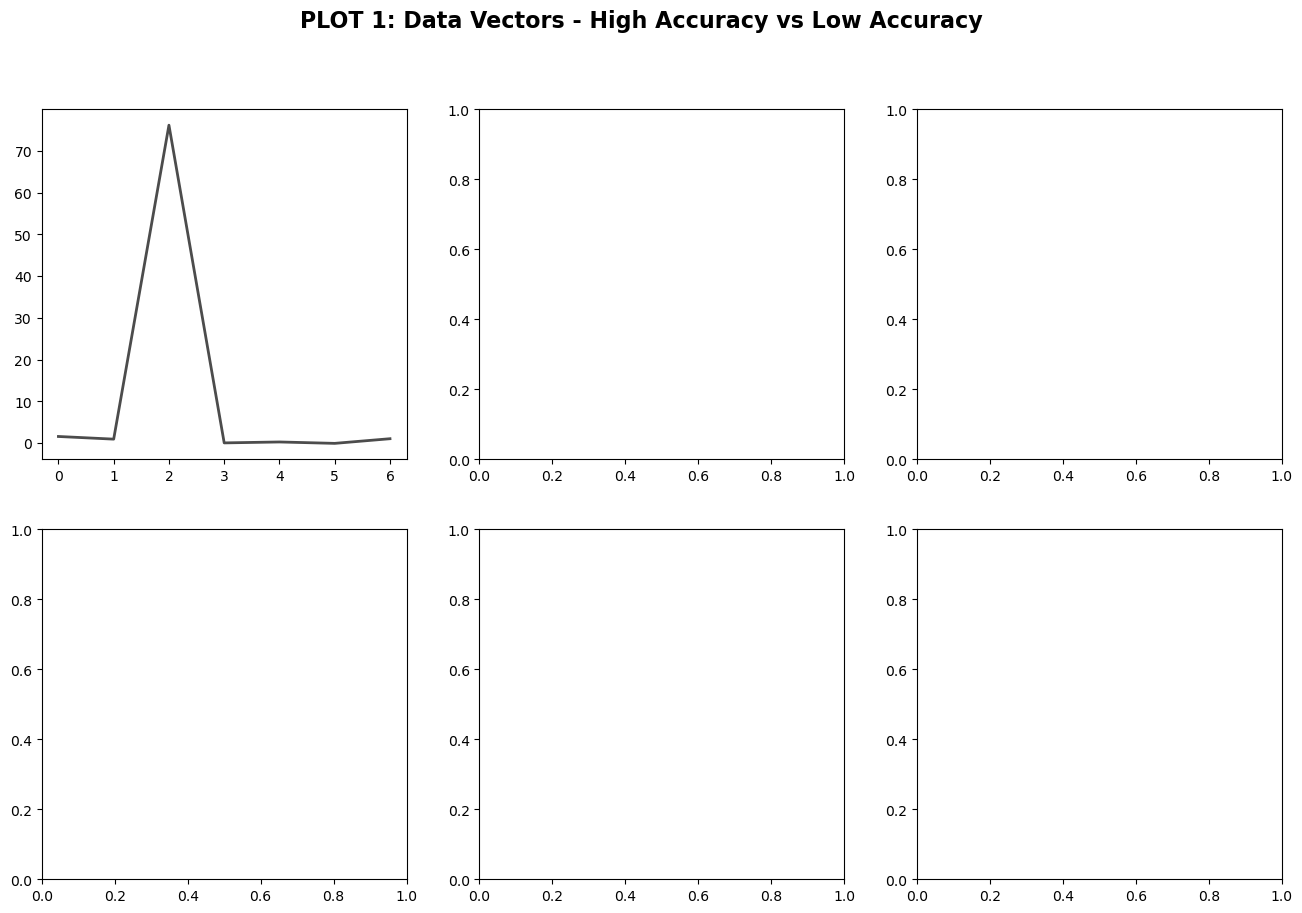

In [11]:
# Select a few random test samples to visualize
n_samples = 5
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('PLOT 1: Data Vectors - High Accuracy vs Low Accuracy', fontsize=16, fontweight='bold')

for i, idx in enumerate(sample_indices):
    if i >= 6:
        break
    ax = axes[i//3, i%3]
    
    # Plot truth and predictions
    ax.plot(y_test[idx], 'k-', linewidth=2, label='Truth', alpha=0.7)
    ax.plot(y_pred_low[idx], 'b--', linewidth=1.5, label='Low Accuracy', alpha=0.8)
    ax.plot(y_pred_high[idx], 'r:', linewidth=2, label='High Accuracy', alpha=0.8)
    
    ax.set_xlabel('Data Vector Index', fontsize=10)
    ax.set_ylabel('ξ (Correlation Function)', fontsize=10)
    ax.set_title(f'Test Sample #{idx}', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot1_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: plot1_model_comparison.png")

In [ ]:
fig, axes = plt.subplots(n_samples, 2, figsize=(14, 3*n_samples))
fig.suptitle('PLOT 2: Truth Data Vectors and Their Fractional Differences', 
             fontsize=16, fontweight='bold')

for i, idx in enumerate(sample_indices):
    # Left: Truth data vector
    axes[i, 0].plot(y_test[idx], 'k-', linewidth=2)
    axes[i, 0].set_xlabel('Data Vector Index')
    axes[i, 0].set_ylabel('ξ (Correlation Function)')
    axes[i, 0].set_title(f'Truth - Sample #{idx}')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Right: Fractional difference (both models)
    axes[i, 1].plot(frac_diff_low[idx], 'b-', linewidth=1.5, label='Low Acc', alpha=0.8)
    axes[i, 1].plot(frac_diff_high[idx], 'r-', linewidth=1.5, label='High Acc', alpha=0.8)
    axes[i, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[i, 1].set_xlabel('Data Vector Index')
    axes[i, 1].set_ylabel('(Pred - Truth) / Truth')
    axes[i, 1].set_title(f'Fractional Difference - Sample #{idx}')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot2_truth_and_frac_diff.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: plot2_truth_and_frac_diff.png")

NameError: name 'y_pred_low' is not defined

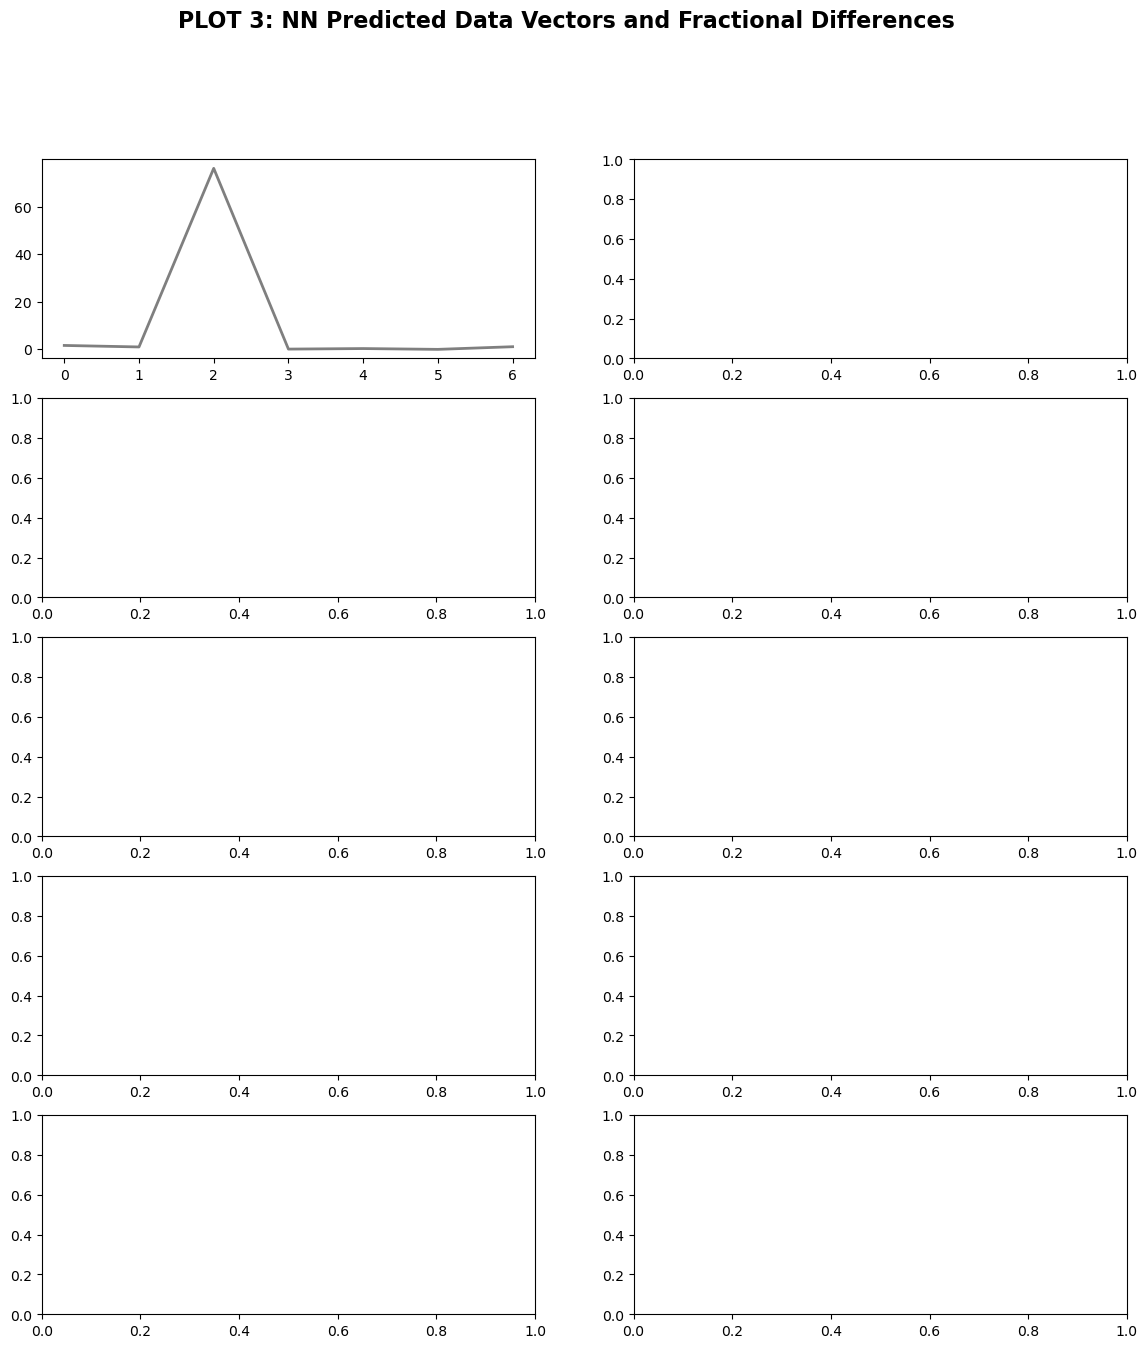

In [12]:
fig, axes = plt.subplots(n_samples, 2, figsize=(14, 3*n_samples))
fig.suptitle('PLOT 3: NN Predicted Data Vectors and Fractional Differences', 
             fontsize=16, fontweight='bold')

for i, idx in enumerate(sample_indices):
    # Left: Predictions
    axes[i, 0].plot(y_test[idx], 'k-', linewidth=2, label='Truth', alpha=0.5)
    axes[i, 0].plot(y_pred_low[idx], 'b--', linewidth=1.5, label='Low Acc Pred')
    axes[i, 0].plot(y_pred_high[idx], 'r:', linewidth=1.5, label='High Acc Pred')
    axes[i, 0].set_xlabel('Data Vector Index')
    axes[i, 0].set_ylabel('ξ (Correlation Function)')
    axes[i, 0].set_title(f'Predictions - Sample #{idx}')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Right: Fractional differences
    axes[i, 1].plot(frac_diff_low[idx], 'b-', linewidth=1.5, label='Low Acc')
    axes[i, 1].plot(frac_diff_high[idx], 'r-', linewidth=1.5, label='High Acc')
    axes[i, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[i, 1].set_xlabel('Data Vector Index')
    axes[i, 1].set_ylabel('(Pred - Truth) / Truth')
    axes[i, 1].set_title(f'Fractional Difference - Sample #{idx}')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot3_predictions_and_frac_diff.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: plot3_predictions_and_frac_diff.png")

In [14]:
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nLow Accuracy Model:")
print(f"  Mean |fractional error|:   {np.abs(frac_diff_low).mean():.6f}")
print(f"  Median |fractional error|: {np.median(np.abs(frac_diff_low)):.6f}")
print(f"  Max |fractional error|:    {np.abs(frac_diff_low).max():.6f}")

print(f"\nHigh Accuracy Model:")
print(f"  Mean |fractional error|:   {np.abs(frac_diff_high).mean():.6f}")
print(f"  Median |fractional error|: {np.median(np.abs(frac_diff_high)):.6f}")
print(f"  Max |fractional error|:    {np.abs(frac_diff_high).max():.6f}")

print(f"\n✓ All 3 plots created successfully!")

SUMMARY STATISTICS

Low Accuracy Model:


NameError: name 'frac_diff_low' is not defined